In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import nltk
import re
import re,string,unicodedata
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")


In [5]:
import pandas as pd
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [6]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [9]:
#checking for null values in train data
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [11]:
#checking for duplicate values
df['headline'].duplicated().sum()

116

In [12]:
df=df.drop(df[df['headline'].duplicated()].index,axis=0)

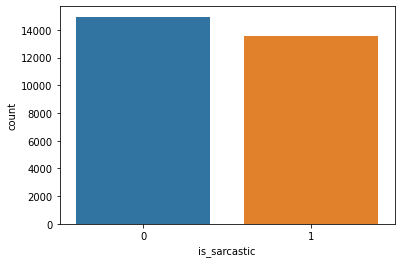

In [13]:
sns.countplot(df['is_sarcastic']);

# Data Preprocessing


In [14]:
# this function is copied from another kernel. Don't know who is the original author of it.
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [15]:
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

In [16]:
labels = (df['is_sarcastic'])
data = (df['headline'])

In [17]:
train_ratio = 0.80

train_size = int(len(labels)*train_ratio)

train_data = data[:train_size]
train_labels= labels[:train_size]

test_data = data[train_size:]
test_labels = labels[train_size:]


In [18]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_data)

vocab_size = len(tokenizer.word_index)
print(vocab_size)

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)



25662


In [19]:
maxlen=max([len(i) for i in train_sequences])

In [20]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen,  padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen,  padding='post')

In [21]:
# Print a sample headline
index = 10
print(f'sample headline: {train_sequences[index]}')
print(f'padded sequence: {train_padded[index]} \n')

print(f'Original Sentence:  \n {tokenizer.sequences_to_texts(train_sequences[index:index+1])} \n')

# Print dimensions of padded sequences
print(f'shape of padded sequences: {train_padded.shape}')

sample headline: [1972, 2572, 315, 3022, 943, 7]
padded sequence: [1972 2572  315 3022  943    7    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] 

Original Sentence:  
 ['lesbian considered father indiana amazing one'] 

shape of padded sequences: (22802, 106)


<a id="7"></a> 
# 5. Data Modeling - LSTM


In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,100,input_length=maxlen),
    tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(128)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2022-11-03 15:20:43.665615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 15:20:43.759424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 15:20:43.760217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 15:20:43.762152: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 106, 100)          2566300   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,817,309
Trainable params: 2,817,309
Non-trainable params: 0
______________________________________________

In [23]:
history=model.fit(train_padded, np.array(train_labels),validation_data = (test_padded,np.array(test_labels)) , epochs = 5 , verbose=2)

2022-11-03 15:20:47.243567: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-11-03 15:20:50.491783: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


713/713 - 15s - loss: 0.4792 - accuracy: 0.7554 - val_loss: 0.4046 - val_accuracy: 0.8132
Epoch 2/5
713/713 - 10s - loss: 0.2083 - accuracy: 0.9175 - val_loss: 0.4537 - val_accuracy: 0.8065
Epoch 3/5
713/713 - 9s - loss: 0.0882 - accuracy: 0.9681 - val_loss: 0.6521 - val_accuracy: 0.8013
Epoch 4/5
713/713 - 9s - loss: 0.0878 - accuracy: 0.9703 - val_loss: 0.7122 - val_accuracy: 0.7932
Epoch 5/5
713/713 - 10s - loss: 0.0336 - accuracy: 0.9878 - val_loss: 0.8482 - val_accuracy: 0.7909


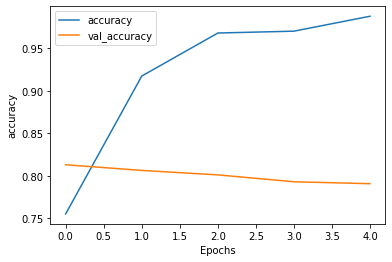

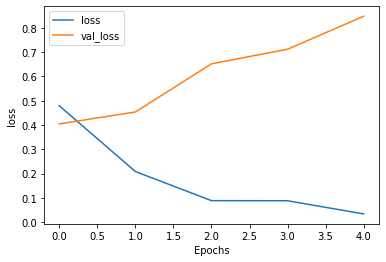

In [24]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(model, string):
  plt.plot(model.history[string])
  plt.plot(model.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Now we take the naive approach to try improve sentiment analysis with sarcasm detection

In [147]:
model_prediction = pd.read_csv('../input/resultsserving/finbert_combined_data_training.csv')
model_prediction


,title,prediction,sentiment
0,The Untapped Potential of Open Financial Data,negative,neutral
1,Government Could Breach Debt Ceiling in Septem...,positive,positive
2,'Green hydrogen now cheaper to produce than gr...,neutral,neutral
3,U.S. telecom regulator circulates Boeing satel...,negative,negative
4,Your delivery orders are making restaurants ma...,positive,positive
...,...,...,...
2042,In praise of â€˜messy economicsâ€™,negative,negative
2043,How Bitcoin Is Helping Venezuelans Survive Hyp...,negative,negative
2044,Twice as many companies paying zero taxes unde...,negative,negative
2045,Super Bowl betting is expected to top $7.6 bil...,negative,negative


In [148]:
#preprocessing following the one used to train sarcasm detector
model_prediction['title']=model_prediction['title'].apply(denoise_text)
model_prediction

,title,prediction,sentiment
0,untapped potential open financial data,negative,neutral
1,government could breach debt ceiling september...,positive,positive
2,green hydrogen cheaper produce grey across eur...,neutral,neutral
3,us telecom regulator circulates boeing satelli...,negative,negative
4,delivery orders making restaurants mad theyre ...,positive,positive
...,...,...,...
2042,praise,negative,negative
2043,bitcoin helping venezuelans survive hyperinfla...,negative,negative
2044,twice many companies paying zero taxes trump t...,negative,negative
2045,super bowl betting expected top billion dont f...,negative,negative


In [149]:
model_prediction_headlines = model_prediction['title']
model_prediction_headlines_sequences = tokenizer.texts_to_sequences(model_prediction_headlines)
model_prediction_headlines_padded = pad_sequences(model_prediction_headlines_sequences, maxlen=maxlen,  padding='post')

In [150]:
sarcasm_score = model.predict(model_prediction_headlines_padded)
model_prediction['sarcasm_score']= sarcasm_score
model_prediction

,title,prediction,sentiment,sarcasm_score
0,untapped potential open financial data,negative,neutral,0.005884
1,government could breach debt ceiling september...,positive,positive,0.001692
2,green hydrogen cheaper produce grey across eur...,neutral,neutral,0.000194
3,us telecom regulator circulates boeing satelli...,negative,negative,0.999444
4,delivery orders making restaurants mad theyre ...,positive,positive,0.072840
...,...,...,...,...
2042,praise,negative,negative,0.011053
2043,bitcoin helping venezuelans survive hyperinfla...,negative,negative,0.124116
2044,twice many companies paying zero taxes trump t...,negative,negative,0.000058
2045,super bowl betting expected top billion dont f...,negative,negative,0.000589


<AxesSubplot:>

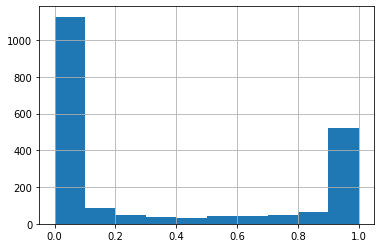

In [151]:
model_prediction['sarcasm_score'].hist()

In [152]:
sarcasm_detected = model_prediction[model_prediction['sarcasm_score'] > 0.9999]
sarcasm_detected

,title,prediction,sentiment,sarcasm_score
28,dow drops points powell triggers jump yields s...,positive,positive,0.999972
47,wendys upgrading french fries,neutral,neutral,0.999941
72,recent years globalization entered new phase d...,negative,negative,0.999931
81,million britons bank account cash usage still ...,positive,positive,0.999925
107,delivery driver slams customers tip baiting cu...,positive,positive,0.999993
...,...,...,...,...
1913,billion tonnes food wasted previously estimate...,positive,positive,0.999987
1953,rural groceries fade away lawmakers wonder whe...,positive,negative,0.999999
1959,almost warming expected next decades could avo...,negative,negative,0.999994
1960,asanas ceo buys billion company stock historic...,negative,negative,0.999969


In [153]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
acc = accuracy_score(model_prediction['sentiment'].to_numpy(), model_prediction['prediction'].to_numpy())
f1 = f1_score(model_prediction['sentiment'].to_numpy(), model_prediction['prediction'].to_numpy(), average='micro')

print("Accuracy Score -",acc)
print("F1 Score - ", f1)

Accuracy Score - 0.8563751831949193
F1 Score -  0.8563751831949193


In [154]:
# if sarcasm and positive sentiment, change to negative
model_prediction.loc[(model_prediction['sarcasm_score']>0.9999) & (model_prediction['prediction']=='positive'), 'prediction'] = 'negative'


In [155]:
acc = accuracy_score(labelled['sentiment'].to_numpy(), labelled['prediction'].to_numpy())
f1 = f1_score(labelled['sentiment'].to_numpy(), labelled['prediction'].to_numpy(), average='micro')

print("Accuracy Score -",acc)
print("F1 Score - ", f1)

Accuracy Score - 0.8426966292134831
F1 Score -  0.842696629213483
